# **Acertijo TPS resolvido con QAOA**

**Importaciones y Funciones**

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.visualization import plot_histogram

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp

def leer(archivo):
      datos = open(archivo, "r")
      nodos = {}
      for linea in datos:
          linea = linea.strip()
          if not linea: continue

          partes = linea.split()
          if len(partes) >= 3:
              try:
                  nombre = int(partes[0])
                  pos_x = float(partes[1])
                  pos_y = float(partes[2])
                  nodos[nombre] = (pos_x, pos_y)
              except ValueError:
                  continue
      return nodos

def dibujar_grafo(nodos, arcos):
    G = nx.Graph()
    for nodo in nodos:
        G.add_node(nodo, pos=nodos[nodo])

    for arco in arcos:
        G.add_edge(arco[0], arco[1], color="black")

    pos = nx.get_node_attributes(G, 'pos')

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(G, pos, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    plt.title("Ruta Óptima Encontrada (QAOA)")
    plt.axis('off')
    plt.show()

def resolver_con_qaoa(nodos, num_ciudades=3):
    print(f"--- Resolviendo TSP para {num_ciudades} ciudades usando QAOA ---")

    if len(nodos) < num_ciudades:
        print(f"Error: El archivo solo tiene {len(nodos)} ciudades, pero pediste {num_ciudades}.")
        return

    claves = list(nodos.keys())[:num_ciudades]
    coords = [nodos[k] for k in claves]

    n = len(coords)
    matriz_dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            d = np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)
            matriz_dist[i][j] = int(d)

    print("Matriz de distancias calculada.")

    tsp_problem = Tsp(matriz_dist)
    qp = tsp_problem.to_quadratic_program()

    optimizer = COBYLA(maxiter=100)
    sampler = StatevectorSampler()
    estimator = StatevectorEstimator()

    qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=1)

    algo = MinimumEigenOptimizer(qaoa)

    print("Ejecutando circuito cuántico (esto puede tardar unos segundos)...")
    resultado = algo.solve(qp)

    ruta_indices = tsp_problem.interpret(resultado)
    print(f"\nRuta encontrada (índices): {ruta_indices}")
    print(f"Distancia total: {resultado.fval}")

    arcos_solucion = []
    for i in range(len(ruta_indices)):
        u_idx = ruta_indices[i]
        v_idx = ruta_indices[(i + 1) % len(ruta_indices)]

        u_real = claves[u_idx]
        v_real = claves[v_idx]

        arcos_solucion.append((u_real, v_real))

    dibujar_grafo(nodos, arcos_solucion)

    try:
        if resultado.samples:
            print("\nDistribución de probabilidades (Top 5):")
            muestras_ordenadas = sorted(resultado.samples, key=lambda x: x.probability, reverse=True)[:5]
            for m in muestras_ordenadas:
                print(f"Estado: {m.x} | Probabilidad: {m.probability:.4f} | Costo: {m.fval}")
    except AttributeError:
        pass

--- Resolviendo TSP para 3 ciudades usando QAOA ---
Matriz de distancias calculada.
Ejecutando circuito cuántico (esto puede tardar unos segundos)...


c:\Users\nacho\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\nacho\venv\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
c:\Users\nacho\venv\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Ruta encontrada (índices): [0, 2, 1]
Distancia total: 931.0


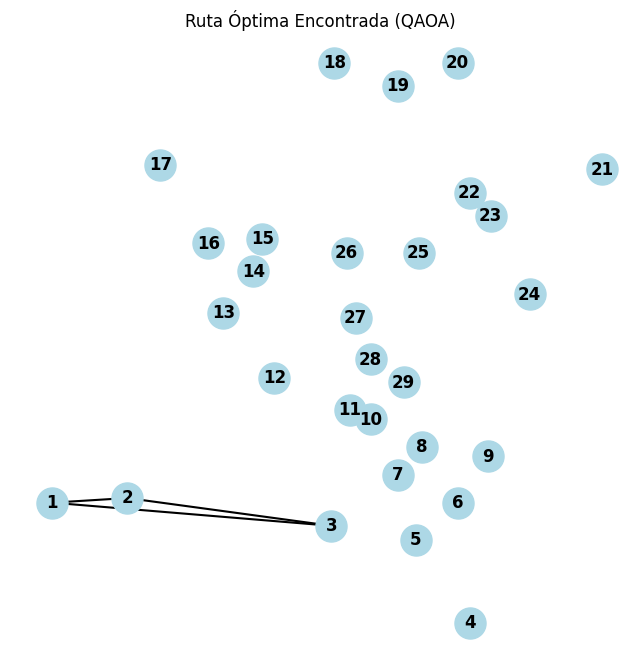


Distribución de probabilidades (Top 5):
Estado: [0. 0. 1. 0. 1. 0. 1. 0. 0.] | Probabilidad: 0.0017 | Costo: 931.0
Estado: [1. 0. 0. 0. 0. 1. 0. 1. 0.] | Probabilidad: 0.0015 | Costo: 931.0
Estado: [1. 0. 0. 0. 1. 0. 0. 0. 1.] | Probabilidad: 0.0013 | Costo: 931.0
Estado: [0. 1. 0. 0. 0. 1. 1. 0. 0.] | Probabilidad: 0.0010 | Costo: 931.0
Estado: [0. 0. 1. 1. 0. 0. 0. 1. 0.] | Probabilidad: 0.0009 | Costo: 931.0


In [2]:
nodos = leer("Europa.txt")
resolver_con_qaoa(nodos, num_ciudades=3)

# **Acertijo TPS resolvido con algoritmo no cuántico**

**Lectura de Archivo**

In [3]:
def leer(archivo):
    datos=open(archivo, "r")
    nodos={}
    c=0
    nombre=""
    pos_x=""
    pos_y=""
    for linea in datos:
        if c>2:
            nombre=int(linea.rstrip('\n')[0:10].replace(" ",""))
            pos_x=float(linea.rstrip('\n')[10:20].replace(" ",""))
            pos_y=float(linea.rstrip('\n')[20:30].replace(" ",""))
            nodos[nombre]= (pos_x,pos_y)
        c=c+1
    return nodos

**Grafo**

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def dibujar_grafo(nodos, arcos):
    G = nx.Graph()

    for nodo in nodos:
        G.add_node(nodo)

    for arco in arcos:
        G.add_edge(arco[0], arco[1], color="black")


    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]

    nx.draw(G, nodos, node_size=30, edge_color=colors)
    #plt.savefig("Imagen"+".pdf")
    plt.show()


**TSP**

Restricted license - for non-production use only - expires 2027-11-29
Set parameter TimeLimit to value 600
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  600
LazyConstraints  1

Optimize a model with 899 rows, 841 columns and 3335 nonzeros (Min)
Model fingerprint: 0x51ffdd26
Model has 812 linear objective coefficients
Variable types: 0 continuous, 841 integer (841 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [4e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 9368.0000000
Presolve removed 435 rows and 29 columns
Presolve time: 0.01s
Presolved: 464 rows, 812 columns, 2436 nonzeros
Variable types: 

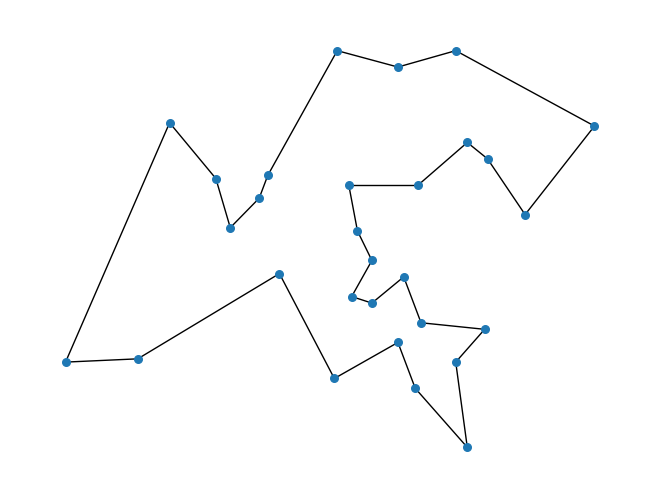

In [5]:
import time
import random
from gurobipy import *
#-----------------------------------------------------------DISTANCIA------------------------------------------------------------
def distancia(nodos,i, j):
        distancia=int(((nodos[i][0]-nodos[j][0])**2+(nodos[i][1]-nodos[j][1])**2)**(1/2))
        return distancia
#---------------------------------------------------------------CALLBACK--------------------------------------------------------
def tsp(m, where):
    if where == GRB.Callback.MIPSOL:
        arcos = []
        for i in nodos:
            for j in nodos:
                solucion = m.cbGetSolution([m._vars[i,j]])
                if solucion[0]>0.5:
                    arcos+=[(i,j)]
        tour= subtour(arcos)
        S=tour[0]
        S_=tour[1]
        if len(S) > 0:
            expr=0
            m.cbLazy(quicksum(m._vars[i,j] for i in S for j in S_) >= 1)
#------------------------------------------------------------SUBTOURS---------------------------------------------------------------
def subtour(arcos):
    S_=[]
    S=[]
    revisados=[]
    actual=1
    S_.append(actual)
    revisados.append(actual)
    while len(revisados)>0:
        actual = revisados[0]
        for arco in arcos:
            if arco[0]==actual and (arco[1] in S_)==False:
                revisados.append(arco[1])
                S_.append(arco[1])
            elif arco[1]==actual and (arco[0] in S_)==False:
                revisados.append(arco[0])
                S_.append(arco[0])
        del revisados[0]
    for nodo in nodos:
        if nodo not in S_:
            S.append(nodo)
    return S,S_
#--------------------------------------------------------MODELO-------------------------------------------------------
def resolver():
    m = Model()
    m.setParam('TimeLimit', 10*60)
    vars={}
    n=0
    for i in nodos:
        for j in nodos:
            if i!=j:
                costo=distancia(nodos,i,j)
                vars[i,j]=m.addVar(obj=costo, vtype=GRB.BINARY, lb=0, ub=1,name='x'+str(i)+'_'+str(j))
            else:
                vars[i,j]=m.addVar(obj=0, vtype=GRB.BINARY, lb=0, ub=0,name='x'+str(i)+'_'+str(j))
    m.update()

    for i in nodos:
        m.addConstr(quicksum(vars[i,j] for j in nodos) == 1)
    m.update()

    for i in nodos:
        m.addConstr(quicksum(vars[j,i] for j in nodos) == 1)
    m.update()

    for i in nodos:
        for j in nodos:
            m.addConstr(vars[i,j]+vars[j,i]<=1)
    m.update()

    m._vars=vars
    m.params.LazyConstraints = 1

    m.setObjective(quicksum(vars[i,j].obj*vars[i,j] for i in nodos for j in nodos), GRB.MINIMIZE)
    m.update()

    m.optimize(tsp)
#-------------------------------------------------------------SOLUCIÓN-------------------------------------------------
    solucion = m.getAttr('x', vars)
    arcos = [(i,j) for i in nodos for j in nodos if solucion[i,j] > 0.5]
    dibujar_grafo(nodos,arcos)
#-------------------------------------------------------------MAIN-------------------------------------------------------
nodos=leer("Europa.txt")
resolver()